<a href="https://colab.research.google.com/github/staerkjoe/ML_colab/blob/main/DiffuisonScratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np

# Set device to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [2]:
# ==================== U-Net Model ====================
class UNet(nn.Module):
    """Simple U-Net for denoising images at different timesteps"""
    def __init__(self, in_channels=1, time_dim=256):
        super().__init__()

        # Time embedding: converts timestep to a feature vector
        self.time_mlp = nn.Sequential(
            nn.Linear(1, time_dim),
            nn.SiLU(),
            nn.Linear(time_dim, time_dim)
        )

        # Encoder (downsampling path)
        self.conv1 = nn.Conv2d(in_channels, 64, 3, padding=1)
        self.conv2 = nn.Conv2d(64, 128, 3, padding=1)
        self.pool = nn.MaxPool2d(2)

        # Bottleneck
        self.bottleneck = nn.Conv2d(128, 256, 3, padding=1)

        # Decoder (upsampling path)
        self.upconv1 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.conv3 = nn.Conv2d(256, 128, 3, padding=1)  # 256 because of skip connection
        self.upconv2 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.conv4 = nn.Conv2d(128, 64, 3, padding=1)   # 128 because of skip connection

        # Output layer: predicts the noise
        self.out = nn.Conv2d(64, in_channels, 1)

    def forward(self, x, t):
        # Time embedding
        t = t.unsqueeze(-1).float() / 1000.0  # Normalize timestep
        t_emb = self.time_mlp(t)
        t_emb = t_emb.view(t_emb.shape[0], -1, 1, 1)  # Reshape for broadcasting

        # Encoder
        x1 = F.relu(self.conv1(x))
        x2 = self.pool(x1)
        x2 = F.relu(self.conv2(x2))
        x3 = self.pool(x2)

        # Bottleneck (add time embedding here)
        x3 = F.relu(self.bottleneck(x3)) + t_emb[:, :256, :, :]

        # Decoder with skip connections
        x = self.upconv1(x3)
        x = torch.cat([x, x2], dim=1)  # Skip connection
        x = F.relu(self.conv3(x))

        x = self.upconv2(x)
        x = torch.cat([x, x1], dim=1)  # Skip connection
        x = F.relu(self.conv4(x))

        return self.out(x)

In [3]:
# ==================== Diffusion Process ====================
class DiffusionModel:
    def __init__(self, timesteps=1000, beta_start=0.0001, beta_end=0.02):
        self.timesteps = timesteps

        # Linear schedule for noise variance
        self.betas = torch.linspace(beta_start, beta_end, timesteps).to(device)
        self.alphas = 1 - self.betas
        self.alphas_cumprod = torch.cumprod(self.alphas, dim=0)

    def forward_diffusion(self, x0, t):
        """Add noise to images according to timestep t (q(x_t | x_0))"""
        noise = torch.randn_like(x0)
        sqrt_alphas_cumprod_t = self.alphas_cumprod[t].sqrt()
        sqrt_one_minus_alphas_cumprod_t = (1 - self.alphas_cumprod[t]).sqrt()

        # Reshape for broadcasting
        sqrt_alphas_cumprod_t = sqrt_alphas_cumprod_t[:, None, None, None]
        sqrt_one_minus_alphas_cumprod_t = sqrt_one_minus_alphas_cumprod_t[:, None, None, None]

        # x_t = sqrt(alpha_bar_t) * x_0 + sqrt(1 - alpha_bar_t) * noise
        return sqrt_alphas_cumprod_t * x0 + sqrt_one_minus_alphas_cumprod_t * noise, noise

    @torch.no_grad()
    def sample(self, model, n_samples=16, img_size=28):
        """Generate images by denoising from pure noise"""
        model.eval()

        # Start from pure noise
        x = torch.randn(n_samples, 1, img_size, img_size).to(device)

        # Reverse diffusion process
        for t in reversed(range(self.timesteps)):
            t_batch = torch.full((n_samples,), t, dtype=torch.long).to(device)

            # Predict noise
            predicted_noise = model(x, t_batch)

            # Compute denoised image
            alpha_t = self.alphas[t]
            alpha_cumprod_t = self.alphas_cumprod[t]
            beta_t = self.betas[t]

            # Mean of reverse process
            x = (1 / alpha_t.sqrt()) * (x - (beta_t / (1 - alpha_cumprod_t).sqrt()) * predicted_noise)

            # Add noise (except for final step)
            if t > 0:
                noise = torch.randn_like(x)
                x = x + beta_t.sqrt() * noise

        return x

In [4]:
# ==================== Data Loading ====================
# Load MNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Normalize to [-1, 1]
])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=2)

print(f"Dataset size: {len(train_dataset)}")

100%|██████████| 9.91M/9.91M [00:00<00:00, 17.9MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 484kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.48MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 8.58MB/s]

Dataset size: 60000


In [5]:
# ==================== Initialize Model and Diffusion ====================
# Create model and diffusion instance
model = UNet(in_channels=1, time_dim=256).to(device)
diffusion = DiffusionModel(timesteps=1000, beta_start=0.0001, beta_end=0.02)

# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")

Model parameters: 968,897


In [6]:
# ==================== Training Loop ====================
num_epochs = 5

model.train()
for epoch in range(num_epochs):
    epoch_loss = 0
    for batch_idx, (images, _) in enumerate(train_loader):
        images = images.to(device)
        batch_size = images.shape[0]

        # Sample random timesteps
        t = torch.randint(0, diffusion.timesteps, (batch_size,)).to(device)

        # Forward diffusion: add noise to images
        noisy_images, noise = diffusion.forward_diffusion(images, t)

        # Predict noise using the model
        predicted_noise = model(noisy_images, t)

        # Compute loss (MSE between predicted and actual noise)
        loss = F.mse_loss(predicted_noise, noise)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

        if batch_idx % 100 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Step [{batch_idx}/{len(train_loader)}], Loss: {loss.item():.4f}")

    avg_loss = epoch_loss / len(train_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}] completed. Average Loss: {avg_loss:.4f}\n")

print("Training completed!")

Epoch [1/5], Step [0/469], Loss: 1.0060
Epoch [1/5], Step [100/469], Loss: 0.0925
Epoch [1/5], Step [200/469], Loss: 0.0562
Epoch [1/5], Step [300/469], Loss: 0.0524
Epoch [1/5], Step [400/469], Loss: 0.0525
Epoch [1/5] completed. Average Loss: 0.0812

Epoch [2/5], Step [0/469], Loss: 0.0423
Epoch [2/5], Step [100/469], Loss: 0.0449
Epoch [2/5], Step [200/469], Loss: 0.0372
Epoch [2/5], Step [300/469], Loss: 0.0357
Epoch [2/5], Step [400/469], Loss: 0.0345
Epoch [2/5] completed. Average Loss: 0.0421

Epoch [3/5], Step [0/469], Loss: 0.0334
Epoch [3/5], Step [100/469], Loss: 0.0430
Epoch [3/5], Step [200/469], Loss: 0.0450
Epoch [3/5], Step [300/469], Loss: 0.0383
Epoch [3/5], Step [400/469], Loss: 0.0321
Epoch [3/5] completed. Average Loss: 0.0369

Epoch [4/5], Step [0/469], Loss: 0.0324
Epoch [4/5], Step [100/469], Loss: 0.0314
Epoch [4/5], Step [200/469], Loss: 0.0351
Epoch [4/5], Step [300/469], Loss: 0.0276
Epoch [4/5], Step [400/469], Loss: 0.0391
Epoch [4/5] completed. Average Lo

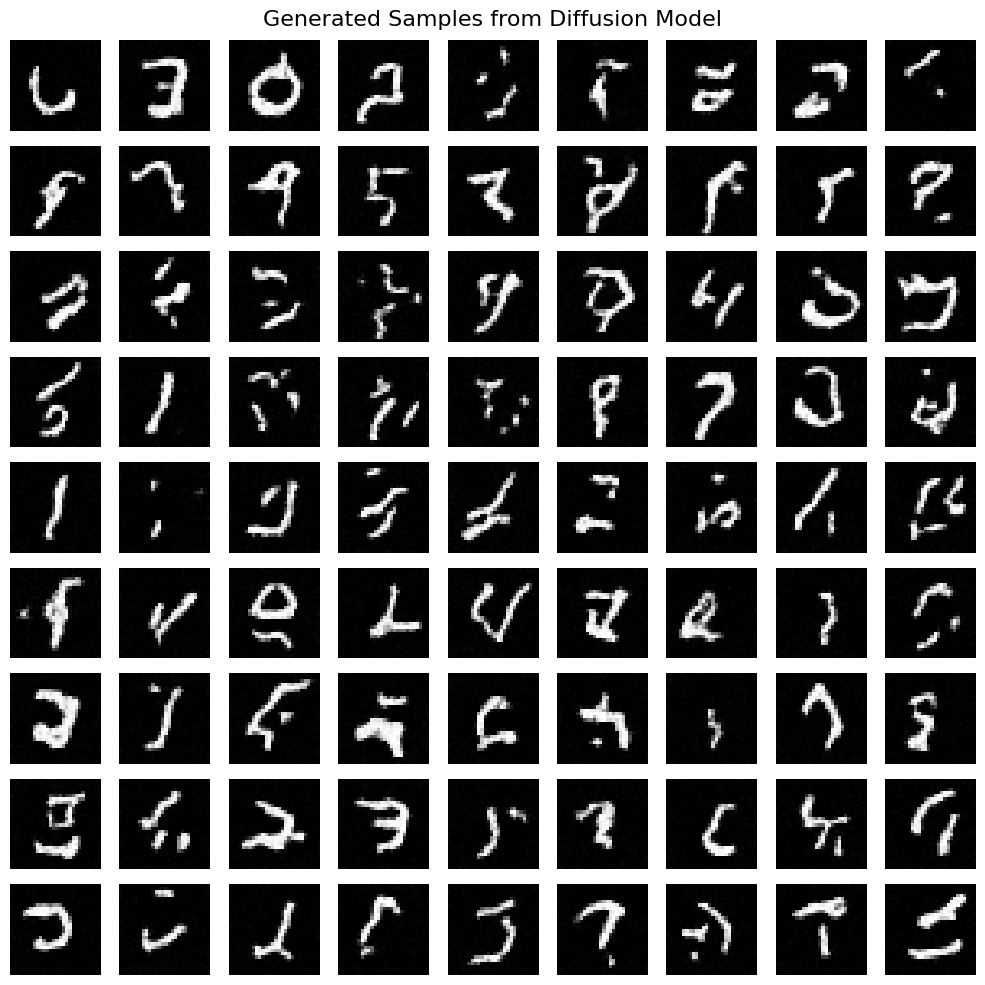

In [8]:
# ==================== Generate and Visualize Samples ====================
# Generate samples
n_samples = 81
generated_images = diffusion.sample(model, n_samples=n_samples, img_size=28)

# Move to CPU and convert to numpy
generated_images = generated_images.cpu().numpy()

# Plot generated samples
fig, axes = plt.subplots(9, 9, figsize=(10, 10))
fig.suptitle('Generated Samples from Diffusion Model', fontsize=16)

for i, ax in enumerate(axes.flat):
    img = generated_images[i, 0]  # Remove channel dimension
    img = (img + 1) / 2  # Denormalize from [-1, 1] to [0, 1]
    img = np.clip(img, 0, 1)  # Clip values to valid range

    ax.imshow(img, cmap='gray')
    ax.axis('off')

plt.tight_layout()
plt.show()